In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from landaupy import langauss
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from tqdm import tqdm
import warnings
from scipy.stats import chisquare
import sys
sys.path.append("../src")
from event_selections import *
from scipy.integrate import quad
from scipy.integrate import IntegrationWarning

In [187]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.simplefilter("error", OptimizeWarning)
warnings.simplefilter("error", IntegrationWarning)
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [3]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=305
pulsed=True
p_folder="../../plots/run_"+str(r_n)

In [4]:
pedestals=pd.read_csv(c_folder+"/pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'mean'])

In [5]:
#mips=pd.read_csv("mip.csv", sep=',')
#mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [6]:
# can and should be improved
def drop_empty(df):
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            #mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                #el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                el=el[el["adc_sum_end0"]>(peds.iloc[0,-2]+5*peds.iloc[0,-1])] 
                el=el[el["adc_max_end0"]!=1023]
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-2]
                
                miniped=peds.iloc[0,-2]/8
                
                el.loc[:,"adc_0_end0"]-=miniped
                el.loc[:,"adc_1_end0"]-=miniped
                el.loc[:,"adc_2_end0"]-=miniped
                el.loc[:,"adc_3_end0"]-=miniped
                el.loc[:,"adc_4_end0"]-=miniped
                el.loc[:,"adc_5_end0"]-=miniped
                el.loc[:,"adc_6_end0"]-=miniped
                el.loc[:,"adc_7_end0"]-=miniped
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event', 'adc_sum_end0','adc_max_end0',
                                     'adc_0','adc_1','adc_2','adc_3',
                                     'adc_4','adc_5','adc_6','adc_7',
                                     'layer', 'strip'])
    
    return df_s

In [7]:
def langau(x,A,x_mpv,xi,sigma):
    return A*langauss.pdf(x=x, landau_x_mpv=x_mpv,landau_xi=xi,gauss_sigma=sigma)

In [8]:
def cs(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)

In [9]:
electron=pd.read_csv(d_folder+"/run_305_pulse.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks','adc_sum_end1',
                               'adc_0_end1','adc_1_end1','adc_2_end1','adc_3_end1',
                               'adc_4_end1','adc_5_end1','adc_6_end1','adc_7_end1'])

#electron=electron.astype({"adc_0_end0":float,"adc_1_end0":float,"adc_2_end0":float,"adc_3_end0":float,
#                          "adc_4_end0":float,"adc_5_end0":float,"adc_6_end0":float,"adc_7_end0":float,})

In [10]:
electron=electron.astype({"adc_0_end0":float,"adc_1_end0":float,"adc_2_end0":float,"adc_3_end0":float,
                          "adc_4_end0":float,"adc_5_end0":float,"adc_6_end0":float,"adc_7_end0":float, 
                          "adc_sum_end0":float})

In [11]:
electron=drop_empty(electron)

In [188]:
def make_fit(row):
    time_steps=np.arange(0,8)
    inter_steps=np.arange(0,8,0.5)
    data=row.iloc[3:-2]
    outpar=[]
    line=[row["layer"], row["strip"], row["adc_sum_end0"], row["adc_max_end0"]]
    error=np.full(6,"nAn")
    with warnings.catch_warnings():
        try:
            param, _ =curve_fit(langau,time_steps, data, p0=[200,2.0,2,3], maxfev=800)
            if param[0]>5:
                
                observed=langau(inter_steps, *param)
                expected=np.interp(inter_steps, time_steps, np.array(data))
                _, pval=cs(observed, expected)
                if pval<1e-25 and pval!=0:
                    line.extend(error)
                    
                else:
                    # return row 
                    integral, _ = quad(langau, 0,7, tuple(param), limit=100, epsabs=1e-1, epsrel=1e-3)
                    true_amp=max(langau(np.arange(0,8,0.01),*param))
                    line.extend(param)
                    line.append(integral)
                    line.append(true_amp)
                    
        except: 
            line.extend(error)
    return line

In [189]:
n=10000
mini_df=electron.head(n)

In [190]:
tqdm.pandas() 
data=mini_df.progress_apply(make_fit, axis=1).values.tolist()
# data=electron.progress_apply(make_fit, axis=1).values.tolist()

100%|█████████████████████████████████████| 10000/10000 [14:38<00:00, 11.38it/s]


In [191]:
param_df=pd.DataFrame(data, columns=["layer", "strip", "adc_sum", "adc_max",
                                     "A", "landau_x_mpv", "landau_xi", "gauss_sigma", 
                                     "fit_integral", "fit_amplitude"])

In [192]:
param_df=param_df.drop(param_df[param_df.A=="nAn"].index)
remain=len(param_df)
print("Failed fits: "+str(round(100*(n-remain)/n,4))+" %")

Failed fits: 11.02 %


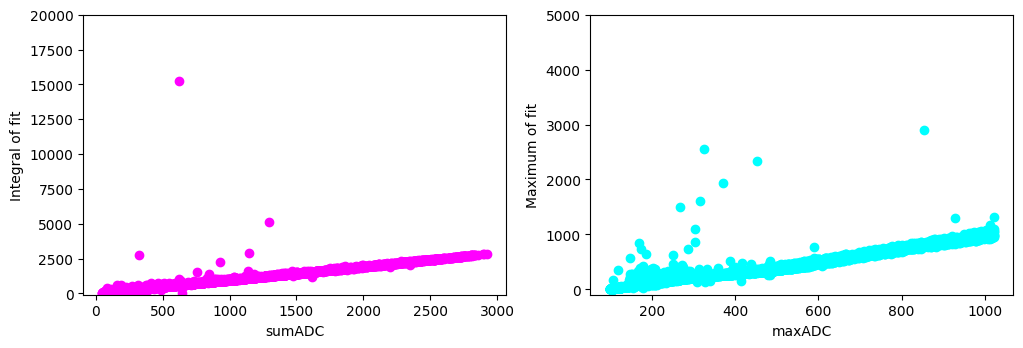

In [194]:
plt.rcParams['figure.figsize']=(12,8)

plt.subplot(2,2,1)
plt.scatter(param_df['adc_sum'], param_df['fit_integral'], c="magenta")
plt.ylabel('Integral of fit')
plt.xlabel('sumADC')
plt.ylim(-100,20000)

plt.subplot(2,2,2)
plt.scatter(param_df['adc_max'], param_df['fit_amplitude'], c="cyan")
plt.ylabel('Maximum of fit')
plt.xlabel('maxADC')
plt.ylim(-100,5000)

plt.savefig(p_folder+"/after_integ_fix.png", bbox_inches='tight')
plt.show()

In [195]:
# plt.rcParams["figure.figsize"]=(6,4)
# a=mini_df[mini_df.index==577].values.tolist()
# fit=param_df[param_df.index==577].values.tolist()
# param=tuple(fit[0][4:-2])
# plt.plot(np.arange(0,8,1),langau(np.arange(0,8,1), *param), color="gray", linestyle='-')
# plt.plot(np.arange(0,8,0.5),langau(np.arange(0,8,0.5), *param), color="magenta")
# plt.scatter(np.arange(0,8),a[0][3:-2], c="black", marker='x', zorder=3)
# plt.ylim(-100,500)
# plt.show()